In [1]:
import numpy as np
# np.bool = np.bool_
import pyarrow #.hdfs
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from pyspark.sql import SparkSession

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("HDFS Parquet Data Analysis") \
    .getOrCreate()

# HDFS에 있는 Parquet 파일의 경로
hdfs_path = "hdfs://hadoop-master:9000/user/root/data/yellow_tripdata_2024-01.parquet"

# HDFS에서 Parquet 파일을 읽어 Spark DataFrame으로 로드
df = spark.read.parquet(hdfs_path)

df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/15 17:10:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



# 데이터 정제

In [3]:
from pyspark.sql import functions as F

# 결측값 확인
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|         140162|            0|    140162|            140162|           0|           0|           0|          0|    0|      0|         

In [4]:
# show()를 명시적으로 쓰지않아도 출력 가능토록(lazy eval 대신 eager)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
df.limit(10)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,N,186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,N,236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,N,79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,N,211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0
1,2024-01-01 00:54:08,2024-01-01 01:26:31,1,4.7,1,N,148,141,1,29.6,3.5,0.5,6.9,0.0,1.0,41.5,2.5,0.0
2,2024-01-01 00:49:44,2024-01-01 01:15:47,2,10.82,1,N,138,181,1,45.7,6.0,0.5,10.0,0.0,1.0,64.95,0.0,1.75
1,2024-01-01 00:30:40,2024-01-01 00:58:40,0,3.0,1,N,246,231,2,25.4,3.5,0.5,0.0,0.0,1.0,30.4,2.5,0.0
2,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,1,N,161,261,2,31.0,1.0,0.5,0.0,0.0,1.0,36.0,2.5,0.0
2,2024-01-01 00:28:08,2024-01-01 00:29:16,1,0.04,1,N,113,113,2,3.0,1.0,0.5,0.0,0.0,1.0,8.0,2.5,0.0


In [6]:
# 결측값이 있는 행 제거
df = df.dropna(how='any')

In [7]:
# 데이터 타입 강제 변환 및 유효성 검사
df = df.withColumn('VendorID', F.col('VendorID').cast('integer')) \
       .withColumn('passenger_count', F.col('passenger_count').cast('integer')) \
       .withColumn('trip_distance', F.col('trip_distance').cast('double')) \
       .withColumn('RatecodeID', F.col('RatecodeID').cast('integer')) \
       .withColumn('payment_type', F.col('payment_type').cast('integer')) \
       .withColumn('fare_amount', F.col('fare_amount').cast('double')) \
       .withColumn('extra', F.col('extra').cast('double')) \
       .withColumn('mta_tax', F.col('mta_tax').cast('double')) \
       .withColumn('tip_amount', F.col('tip_amount').cast('double')) \
       .withColumn('tolls_amount', F.col('tolls_amount').cast('double')) \
       .withColumn('improvement_surcharge', F.col('improvement_surcharge').cast('double')) \
       .withColumn('total_amount', F.col('total_amount').cast('double')) \
       .withColumn('congestion_surcharge', F.col('congestion_surcharge').cast('double')) \
       .withColumn('Airport_fee', F.col('Airport_fee').cast('double')) \
.withColumn('tpep_pickup_datetime', F.col('tpep_pickup_datetime').cast('timestamp')) \
.withColumn('tpep_dropoff_datetime', F.col('tpep_dropoff_datetime').cast('timestamp'))

# 유효한 날짜 확인 (픽업 시간이 드롭오프 시간보다 이후일 수 없음)
df = df.filter(F.col('tpep_dropoff_datetime') > F.col('tpep_pickup_datetime'))


In [8]:
# 특이값이 포함된 행 제거
df = df.select('*').where((df.VendorID >= 1) | (df.VendorID <= 2)) \
.where(df.tpep_pickup_datetime < df.tpep_dropoff_datetime) \
.where(df.passenger_count > 0) \
.where(df.trip_distance > 0) \
.where((df.RatecodeID > 0) | (df.RatecodeID <= 6)) \
.where((df.payment_type > 0) | (df.payment_type <= 6)) \
.where(df.fare_amount > 0) \
.where(df.extra >= 0) \
.where(df.mta_tax >= 0) \
.where(df.tip_amount >= 0) \
.where(df.tolls_amount >= 0) \
.where(df.total_amount >= 0) \
.where(df.congestion_surcharge >= 0) \
.where(df.Airport_fee >= 0)

df

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,N,186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,N,236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,N,79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,N,211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0
1,2024-01-01 00:54:08,2024-01-01 01:26:31,1,4.7,1,N,148,141,1,29.6,3.5,0.5,6.9,0.0,1.0,41.5,2.5,0.0
2,2024-01-01 00:49:44,2024-01-01 01:15:47,2,10.82,1,N,138,181,1,45.7,6.0,0.5,10.0,0.0,1.0,64.95,0.0,1.75
2,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,1,N,161,261,2,31.0,1.0,0.5,0.0,0.0,1.0,36.0,2.5,0.0
2,2024-01-01 00:28:08,2024-01-01 00:29:16,1,0.04,1,N,113,113,2,3.0,1.0,0.5,0.0,0.0,1.0,8.0,2.5,0.0
2,2024-01-01 00:35:22,2024-01-01 00:41:41,2,0.75,1,N,107,137,1,7.9,1.0,0.5,0.0,0.0,1.0,12.9,2.5,0.0


In [9]:
# 정제 후 데이터 확인
df.describe().show()

# 스키마 확인
df.printSchema()

24/08/15 17:10:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+
|summary|           VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|       payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+----------------

## 평균 여행 기간

In [10]:
# 1.평균 여행 기간
# 여행 기간 계산 (초 단위로)
df = df.withColumn('travel_time', 
                   F.col('tpep_dropoff_datetime') - F.col('tpep_pickup_datetime'))

# 평균 여행 기간 계산
mean_travel_time = df.select(F.mean('travel_time')).collect()[0][0]
print(f"Mean Travel Time: {mean_travel_time} seconds")

Mean Travel Time: 0:15:45.834197 seconds


## 평균 여행 거리

In [11]:
from pyspark.sql.functions import avg, col
col
# 2.평균 여행 거리
mean_trip_distance = df.select(avg(col('trip_distance')))
print(f"Mean Trip Distance: \n{mean_trip_distance} miles")

Mean Trip Distance: 
+------------------+
|avg(trip_distance)|
+------------------+
|3.3024493115178477|
+------------------+
 miles


## 피크 시간 분석

+----+------+
|hour| count|
+----+------+
|   0| 69185|
|   1| 45375|
|   2| 31932|
|   3| 20548|
|   4| 12782|
|   5| 15627|
|   6| 35583|
|   7| 74312|
|   8|105117|
|   9|119390|
|  10|130035|
|  11|141256|
|  12|153601|
|  13|159083|
|  14|171268|
|  15|176967|
|  16|178408|
|  17|191253|
|  18|195915|
|  19|170587|
+----+------+
only showing top 20 rows



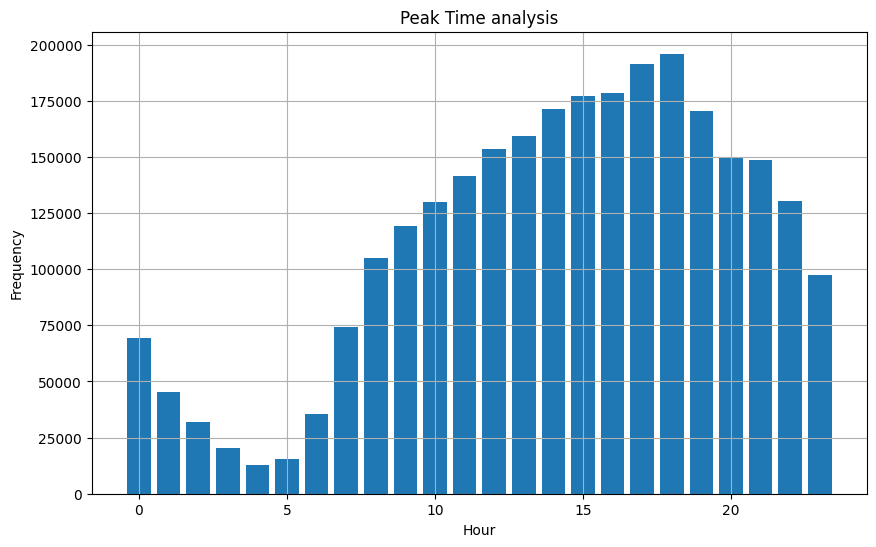

In [12]:
# 'tpep_pickup_datetime' 열에서 시간 정보를 추출하고, 시간 단위로 그룹화하여 여행 수 계산
df_hourly_counts = df.withColumn("hour", F.hour("tpep_pickup_datetime")) \
                     .groupBy("hour") \
                     .count() \
                     .orderBy("hour")

df_hourly_counts.show()

# 결과 시각화
import matplotlib.pyplot as plt

df_pandas = df_hourly_counts.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(df_pandas['hour'], df_pandas['count'])
plt.title('Peak Time analysis')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## 날씨 상태 분석

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, to_number, date_sub

# HDFS에 있는 Parquet 파일의 경로
hdfs_weather_data_path = "hdfs://hadoop-master:9000/user/root/data/jan_2024_weather_data.csv"

# HDFS에서 Parquet 파일을 읽어 Spark DataFrame으로 로드
weather_df = spark.read.csv(hdfs_weather_data_path, header=True)

weather_df.printSchema()

# 날짜를 맞추기위해 임의로 수정합니다
#date_sub(to_timestamp('Datetime'), 365)) \

weather_df = weather_df.withColumn('Datetime', to_timestamp('Datetime')) \
.withColumn('Temperature', col('Temperature').cast('double')) \
.withColumn('Pressure', col('Pressure').cast('double'))

weather_df.limit(5).show()

# weather['Datetime'] = pd.to_datetime(weather['Datetime'])
# weather['Datetime'] = weather['Datetime'] - pd.DateOffset(years=1)
# weather

root
 |-- Datetime: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- Wind Speed: string (nullable = true)
 |-- Pressure: string (nullable = true)
 |-- Condition: string (nullable = true)

+-------------------+-----------+--------+----------+--------+---------+
|           Datetime|Temperature|Humidity|Wind Speed|Pressure|Condition|
+-------------------+-----------+--------+----------+--------+---------+
|2024-01-01 00:51:00|       2.22|     64%|      8mph|   30.06|     Fair|
|2024-01-01 00:52:00|       2.22|     64%|      8mph|   30.06|     Fair|
|2024-01-01 00:53:00|       2.22|     64%|      8mph|   30.06|     Fair|
|2024-01-01 00:54:00|       2.22|     64%|      8mph|   30.06|     Fair|
|2024-01-01 00:55:00|       2.22|     64%|      8mph|   30.06|     Fair|
+-------------------+-----------+--------+----------+--------+---------+



+----------+--------------------+-------------------+
|      date|           Condition|Average Temperature|
+----------+--------------------+-------------------+
|2024-01-01|                Fair|  5.787825773938123|
|2024-01-02|                Fair|  2.693187499999981|
|2024-01-03|                Fair|   3.98083333333331|
|2024-01-04|              Cloudy| 3.9223958333333364|
|2024-01-05|        Fair / Windy| 0.4577916666666623|
|2024-01-06|                Fair| 1.5149444444444524|
|2024-01-07|  Light Rain / Windy|  2.782812500000008|
|2024-01-08|       Mostly Cloudy|   4.45152083333337|
|2024-01-09|                Fair|  6.715951388888872|
|2024-01-10|  Heavy Rain / Windy| 10.062062499999927|
|2024-01-11|      Cloudy / Windy|  6.899583333333395|
|2024-01-12|       Mostly Cloudy|   7.31402083333332|
|2024-01-13|  Light Rain / Windy|  9.678291666666702|
|2024-01-14|Mostly Cloudy / W...| 1.8141041666666402|
|2024-01-15|                Fair|-2.8510694444444553|
|2024-01-16|          Light 

+----------+------+
|      date| count|
+----------+------+
|2024-01-30| 94637|
|2024-01-28| 82222|
|2024-01-26| 97784|
|2024-01-31| 95353|
|2024-01-24| 98104|
|2024-02-01|     3|
|2024-01-27|102259|
|2024-01-29| 78988|
|2024-01-25|101630|
|2024-01-07| 62407|
|2024-01-11| 98083|
|2024-01-02| 70488|
|2024-01-09| 83593|
|2024-01-13| 96558|
|2024-01-05| 96370|
|2024-01-04| 96781|
|2024-01-10| 88869|
|2024-01-12| 95741|
|2024-01-03| 77440|
|2024-01-08| 74995|
+----------+------+
only showing top 20 rows



+----------+------+--------------------+-------------------+
|      date| count|           Condition|Average Temperature|
+----------+------+--------------------+-------------------+
|2024-01-01| 67408|                Fair|  5.787825773938123|
|2024-01-02| 70488|                Fair|  2.693187499999981|
|2024-01-03| 77440|                Fair|   3.98083333333331|
|2024-01-04| 96781|              Cloudy| 3.9223958333333364|
|2024-01-05| 96370|        Fair / Windy| 0.4577916666666623|
|2024-01-06| 88636|                Fair| 1.5149444444444524|
|2024-01-07| 62407|  Light Rain / Windy|  2.782812500000008|
|2024-01-08| 74995|       Mostly Cloudy|   4.45152083333337|
|2024-01-09| 83593|                Fair|  6.715951388888872|
|2024-01-10| 88869|  Heavy Rain / Windy| 10.062062499999927|
|2024-01-11| 98083|      Cloudy / Windy|  6.899583333333395|
|2024-01-12| 95741|       Mostly Cloudy|   7.31402083333332|
|2024-01-13| 96558|  Light Rain / Windy|  9.678291666666702|
|2024-01-14| 85661|Mostl

+--------------------+-----+
|           Condition|count|
+--------------------+-----+
|              Cloudy|  127|
|                Fair|    9|
|       Mostly Cloudy|    3|
|          Light Rain|    2|
|                Mist|    2|
|  Light Rain / Windy|    2|
|          Light Snow|    2|
|Mostly Cloudy / W...|    2|
|  Heavy Rain / Windy|    1|
|      Cloudy / Windy|    1|
|        Fair / Windy|    1|
+--------------------+-----+



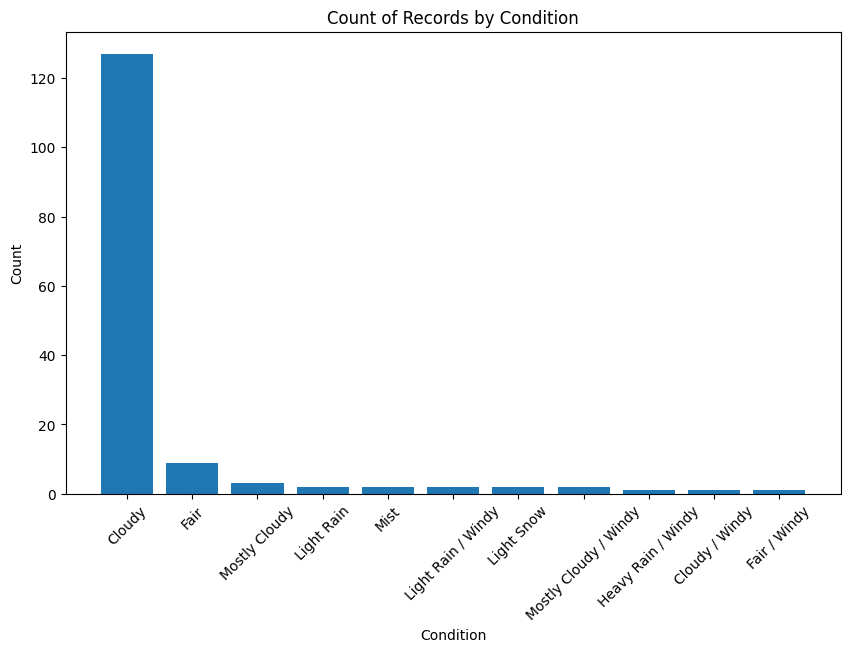

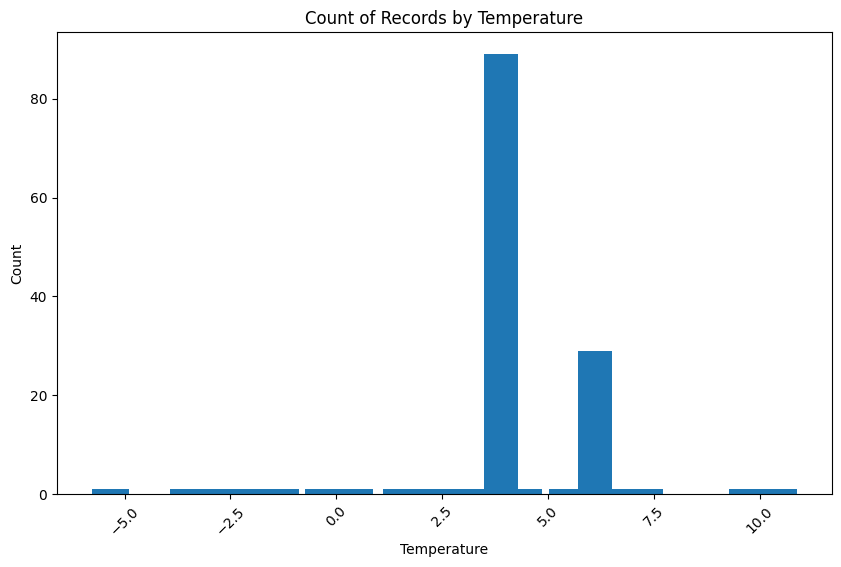

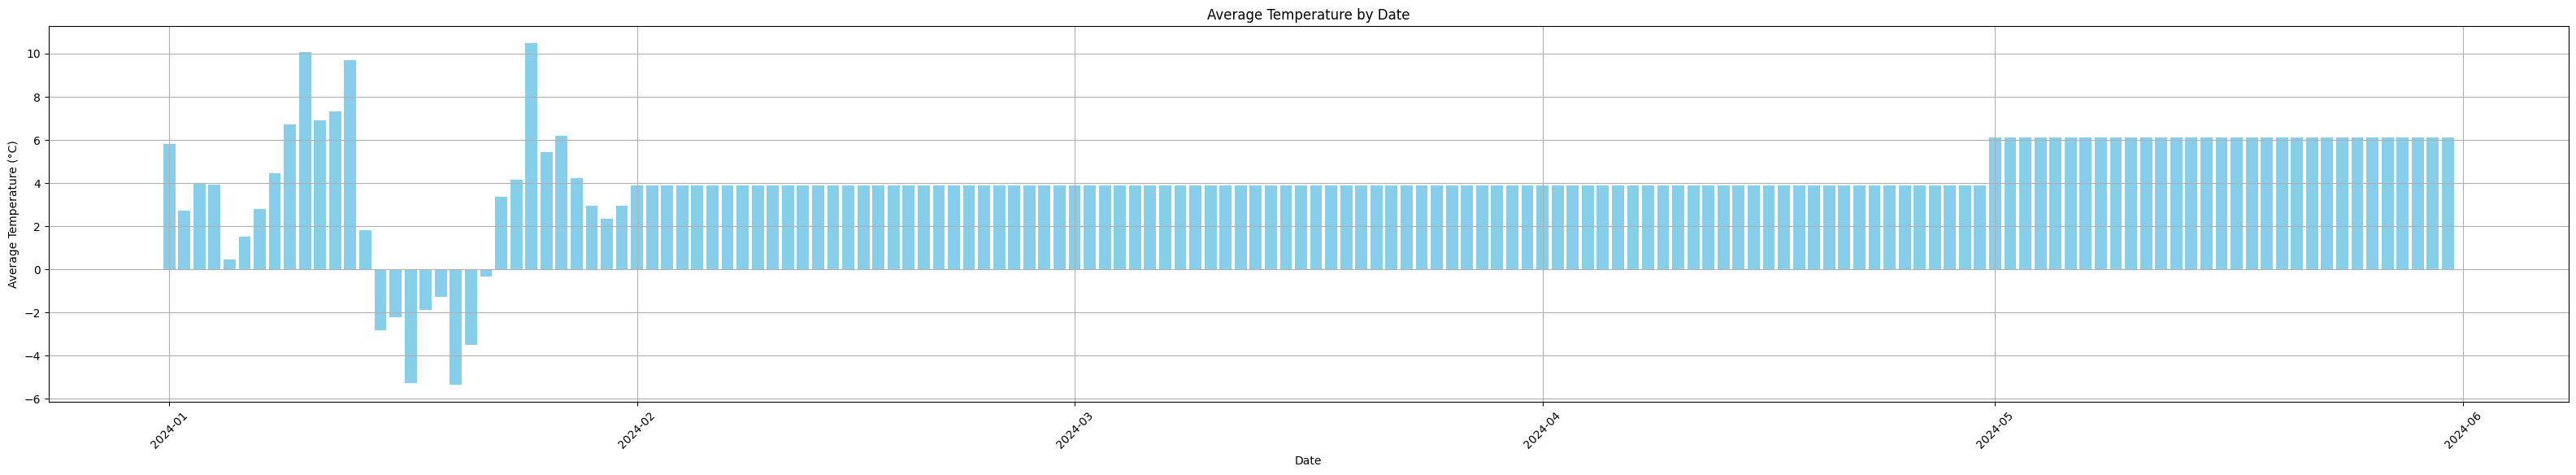

In [21]:
# 날짜 계산
weather_df = weather_df.withColumn('date', F.to_date(weather_df['Datetime']))

# 하루의 대표 Condition과 평균 Temperature 계산
representative_condition = weather_df.groupBy('date') \
                                     .agg(F.expr('first(Condition)').alias('Condition'),
                                          F.avg('Temperature').alias('Average Temperature'))

representative_condition.show()

# 2023-01-01부터 2023-05-31까지의 데이터만 필터링
filtered_df = df.filter((df.tpep_pickup_datetime >= '2024-01-01') & (df.tpep_pickup_datetime <= '2024-06-01'))

# 날짜별로 그룹화하여 여행 수 계산
date_counts = filtered_df.withColumn('date', F.to_date('tpep_pickup_datetime')) \
                         .groupBy('date') \
                         .count()

date_counts.show()

# 날씨 데이터와 병합
merged_df = date_counts.join(representative_condition, on='date', how='outer')

merged_df.show()

# Condition별 레코드 수 계산 및 시각화
condition_counts = merged_df.groupBy('Condition').count().orderBy('count', ascending=False)

condition_counts.show()

condition_counts_pandas = condition_counts.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(condition_counts_pandas['Condition'], condition_counts_pandas['count'])
plt.title('Count of Records by Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Temperature별 레코드 수 계산 및 시각화
temperature_counts = merged_df.groupBy('Average Temperature').count().orderBy('Average Temperature')

temperature_counts_pandas = temperature_counts.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(temperature_counts_pandas['Average Temperature'], temperature_counts_pandas['count'])
plt.title('Count of Records by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 날짜별 평균 기온 시각화
plt.figure(figsize=(40, 6))
result_pandas = representative_condition.toPandas()
plt.bar(result_pandas['date'], result_pandas['Average Temperature'], color='skyblue')
plt.title('Average Temperature by Date')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [22]:
# Parquet 형식으로 HDFS에 저장
hdfs_path = 'hdfs://hadoop-master:9000/user/root/output/result.parquet'
merged_df.write.parquet(hdfs_path)

print(f'Spark DataFrame successfully saved to HDFS at {hdfs_path}')

Spark DataFrame successfully saved to HDFS at hdfs://hadoop-master:9000/user/root/output/result.parquet
